In [2]:
import nbimport
import sympy
import Body_6DOF_Euler_Kinematics as kin
import pylab as pl
import numpy
import scipy.optimize
import control

importing IPython notebook from Body 6DOF Euler Kinematics.ipynb


# Forces and Moments

In [3]:
g, k_mf, k_mt, tau_m, u_roll, u_pitch, u_thr, u_yaw = sympy.symbols('g, k_fm, k_tm, tau_m u_roll u_pitch u_thr, u_yaw')
t = kin.t

In [4]:
omega_1, omega_2, omega_3, omega_4 = sympy.symbols('omega_1, omega_2, omega_3, omega_4')
d_1, d_2, d_3, d_4 = sympy.symbols('d_1 d_2 d_3 d_4')
motor_eoms = {mi(t).diff(t): (di - mi(t))/tau_m for mi, di in zip(
    [omega_1, omega_2, omega_3, omega_4], [d_1, d_2, d_3, d_4])}
motor_eoms

⎧     d₁ - ω₁       d₂ - ω₂       d₃ - ω₃       d₄ - ω₄⎫
⎨ω₁̇: ───────, ω₂̇: ───────, ω₃̇: ───────, ω₄̇: ───────⎬
⎩       τ_m           τ_m           τ_m           τ_m  ⎭

In [5]:
u_vect = sympy.Matrix([u_roll, u_pitch, u_thr, u_yaw])
motor_mix_matrix = pl.array([
    # roll, pitch, thr, yaw
    [-1, 1, 1, -1],
    [1, -1, 1, -1],
    [1, 1, 1, 1],
    [-1, -1, 1, 1],
])
motor_mix = motor_mix_matrix*u_vect
d = [d_1, d_2, d_3, d_4]
sub_mix = {d[i]: motor_mix[i] for i in range(len(d))}
sub_mix

{d₁: u_pitch - u_roll + u_thr - u_yaw, d₂: -u_pitch + u_roll + u_thr - u_yaw, 
d₃: u_pitch + u_roll + u_thr + u_yaw, d₄: -u_pitch - u_roll + u_thr + u_yaw}

In [6]:
motor_eoms = {key:val.subs(sub_mix) for key, val in motor_eoms.iteritems()}
motor_eoms

⎧     u_pitch - u_roll + u_thr - u_yaw - ω₁       -u_pitch + u_roll + u_thr - 
⎨ω₁̇: ─────────────────────────────────────, ω₂̇: ────────────────────────────
⎩                      τ_m                                         τ_m        

u_yaw - ω₂       u_pitch + u_roll + u_thr + u_yaw - ω₃       -u_pitch - u_roll
──────────, ω₃̇: ─────────────────────────────────────, ω₄̇: ─────────────────
                                  τ_m                                         

 + u_thr + u_yaw - ω₄⎫
─────────────────────⎬
τ_m                  ⎭

In [7]:
theta_f, theta_b, l_f, l_b = sympy.symbols('theta_f theta_b l_f l_b')

In [8]:
class Arm(object):
    def __init__(self, kin, theta, l, m, d):
        self.kin = kin
        self.theta = theta
        self.l = l
        self.m = m
        self.d = d
    def F(self):
        return -k_mf*self.m**2*self.kin.frame_b.z
    def M(self):
        frame_a = kin.frame_b.orientnew('a', 'Axis', (self.theta, kin.frame_b.z))
        point_a = kin.point_cm.locatenew('arm_1', self.l*frame_a.x)
        return k_mt*self.d*self.m**2*self.kin.frame_b.z + point_a.pos_from(kin.point_cm).cross(self.F())

In [9]:
arms = [
    Arm(kin, theta_f, l_f, omega_1, -1),
    Arm(kin, -theta_b, l_b, omega_2, -1),
    Arm(kin, -theta_f, l_f, omega_3, 1),
    Arm(kin, theta_b, l_b, omega_4, 1)]
F = kin.m*g*kin.frame_i.z
M = 0*kin.frame_b.x
for arm in arms:
    F += arm.F()
    M += arm.M()
F = F.simplify()
M = M.simplify()
sub_F = {xi(t): F.dot(unit) for xi, unit in zip([kin.F_bx, kin.F_by, kin.F_bz],
                                         [kin.frame_b.x, kin.frame_b.y, kin.frame_b.z])}
sub_F

⎧                                                                           ⎛ 
⎨F_bx: -g⋅m⋅sin(θ), F_by: g⋅m⋅sin(φ)⋅cos(θ), F_bz: g⋅m⋅cos(φ)⋅cos(θ) - k_fm⋅⎝ω
⎩                                                                             

 2     2     2     2⎞⎫
₁  + ω₂  + ω₃  + ω₄ ⎠⎬
                     ⎭

In [10]:
sub_M = {xi(t): M.dot(unit) for xi, unit in zip([kin.M_bx, kin.M_by, kin.M_bz],
                                         [kin.frame_b.x, kin.frame_b.y, kin.frame_b.z])}
sub_M

⎧           ⎛      2                  2                  2                  2 
⎨M_bx: k_fm⋅⎝l_b⋅ω₂ ⋅sin(θ_b) - l_b⋅ω₄ ⋅sin(θ_b) - l_f⋅ω₁ ⋅sin(θ_f) + l_f⋅ω₃ ⋅
⎩                                                                             

        ⎞             ⎛      2                  2                  2          
sin(θ_f)⎠, M_by: k_fm⋅⎝l_b⋅ω₂ ⋅cos(θ_b) + l_b⋅ω₄ ⋅cos(θ_b) + l_f⋅ω₁ ⋅cos(θ_f) 
                                                                              

        2         ⎞             ⎛    2     2     2     2⎞⎫
+ l_f⋅ω₃ ⋅cos(θ_f)⎠, M_bz: k_tm⋅⎝- ω₁  - ω₂  + ω₃  + ω₄ ⎠⎬
                                                         ⎭

# State Space Realization

In [11]:
x_vect = kin.x_vect
x_vect = x_vect.col_join(sympy.Matrix([omega_1, omega_2, omega_3, omega_4]))
sub_no_t = {xi(t):xi for xi in list(x_vect) + list(u_vect)}
x_names = {str(x_vect[i]):i for i in range(len(x_vect))}
u_names = {str(u_vect[i]):i for i in range(len(u_vect))}
x_vect.T, u_vect.T

([U  V  W  P  Q  R  φ  θ  ψ  p_N  p_E  p_D  ω₁  ω₂  ω₃  ω₄], [u_roll  u_pitch 
 u_thr  u_yaw])

In [12]:
g_vect = x_vect

In [13]:
eoms = kin.eoms
eoms.update(motor_eoms)
f_vect = sympy.Matrix([eoms[xi(t).diff(t)] for xi in x_vect]).subs(sub_F).subs(sub_M).subs(sub_no_t)
f_vect

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                          g⋅m
⎢                                                             -P⋅V + Q⋅U + ───
⎢                                                                             
⎢                                                                             
⎢ ⎛    ⎛                                 ⎛    2     2     2     2⎞⎞      ⎛    
⎢-⎝Jxz⋅⎝Jx⋅P⋅Q + Jxz⋅Q⋅R - Jy⋅P⋅Q + k_tm⋅⎝- ω₁  - ω₂  + ω₃  + ω₄ ⎠⎠ + Jz⋅⎝Jxz⋅
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                   

# Trim

In [14]:
sub_const = {
    kin.Jx:1,
    kin.Jy:1,
    kin.Jz:1,
    kin.Jxz:0,
    kin.m:1,
    k_mf:10,
    k_mt:0.1,
    theta_f:0.7,
    theta_b:2,
    tau_m:0.1,
    l_f:0.8,
    l_b:1,
    g:9.8,
}
sub_x0 = {
    kin.phi:0,
    kin.theta:0,
    kin.psi:0,
    kin.U:0,
    kin.V:0,
    kin.W:0,
    kin.P:0,
    kin.Q:0,
    kin.R:0,
}

In [15]:
f_eval = sympy.lambdify((x_vect, u_vect), f_vect.subs(sub_const), [{'ImmutableMatrix': numpy.array}, 'numpy'])
def cost(u):
    e = f_eval(pl.hstack([pl.zeros(12), motor_mix_matrix.dot(u)]), u)
    return e.T.dot(e)

In [16]:
trim = scipy.optimize.minimize(fun=cost, x0=pl.array([0,0,0.4,0]))
u0 = trim['x']
x0 = pl.hstack([pl.zeros(12), motor_mix_matrix.dot(u0)])
trim

   status: 0
  success: True
     njev: 23
     nfev: 138
 hess_inv: array([[  4.40761939e-01,  -2.91422282e-04,  -5.85542854e-04,
          1.21186009e+00],
       [ -2.91422282e-04,   1.25802986e-03,   6.99647901e-05,
         -7.81936288e-04],
       [ -5.85542854e-04,   6.99647901e-05,   2.95994650e-04,
         -1.64332961e-03],
       [  1.21186009e+00,  -7.81936288e-04,  -1.64332961e-03,
          3.33634880e+00]])
      fun: 6.421530632331248e-11
        x: array([ -7.64594327e-06,  -4.73365950e-02,   4.92706039e-01,
        -2.10427602e-05])
  message: 'Optimization terminated successfully.'
      jac: array([ -1.63251000e-06,   3.62615871e-07,   6.51719174e-06,
         6.29333069e-07])

# Linearization

In [17]:
A = f_vect.jacobian(x_vect).applyfunc(lambda e: e.simplify())
B = f_vect.jacobian(u_vect)
C = g_vect.jacobian(x_vect)
D = g_vect.jacobian(u_vect)

In [18]:
sub_x0 = {x_vect[i]: x0[i] for i in range(len(x_vect))}

In [19]:
ss0 = control.ss(*[pl.array(xi.subs(sub_const).subs(sub_x0)).astype(float) for xi in [A, B, C, D]])

# Linear Analysis

In [20]:
def clean_tf(tf, tol=1e-3):
    den = pl.where(abs(pl.array(tf.den)) > 1e-3, tf.den, pl.zeros(len(tf.den)))[0,0,:]
    num = pl.where(abs(pl.array(tf.num)) > 1e-3, tf.num, pl.zeros(len(tf.num)))[0,0,:]
    return control.tf(num[1], den)

## Roll Channel

In [21]:
tf_u_roll_2_phi = clean_tf(control.ss2tf(ss0[x_names['phi'], u_names['u_roll']]))
tf_u_roll_2_phi


    288.2
------------
s^3 + 10 s^2

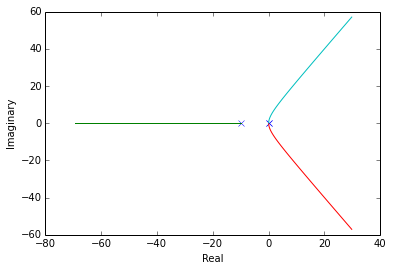

In [22]:
control.rlocus(tf_u_roll_2_phi);  

/usr/local/lib/python2.7/dist-packages/control/freqplot.py:124: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (omega == None):


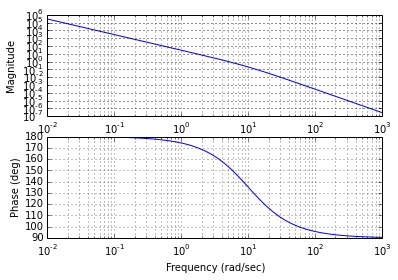

In [23]:
control.bode(tf_u_roll_2_phi, omega=pl.logspace(-2,3));

In [24]:
tf_u_roll_2_phi


    288.2
------------
s^3 + 10 s^2

In [25]:
cntr_roll = 1*control.tf([1, 1], [1])
cntr_roll


s + 1
-----
  1

(None, 29.003953701174396, 15.592451877598677, None)

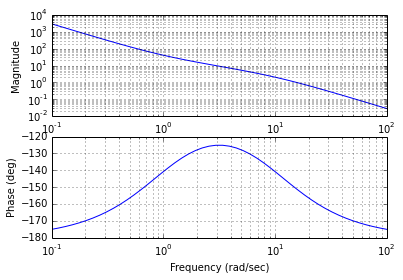

In [26]:
control.bode(tf_u_roll_2_phi*cntr_roll, omega=pl.logspace(-1,2));
control.margin(tf_u_roll_2_phi*cntr_roll)

/usr/local/lib/python2.7/dist-packages/control/matlab.py:1136: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if klist == None:


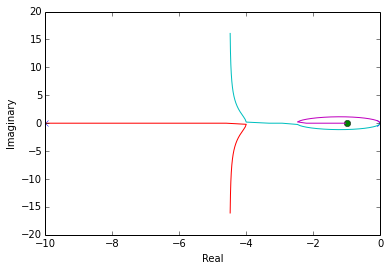

In [27]:
control.rlocus(tf_u_roll_2_phi*cntr_roll, klist=pl.linspace(0,1,1000));

## Pitch Channel

In [28]:
tf_u_pitch_2_theta = clean_tf(control.ss2tf(ss0[x_names['theta'], u_names['u_pitch']]))
tf_u_pitch_2_theta


    198.9
------------
s^3 + 10 s^2

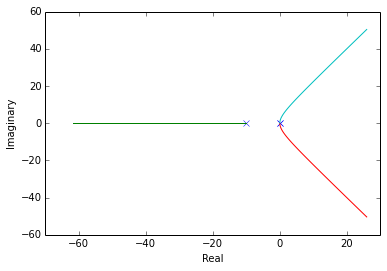

In [29]:
control.rlocus(tf_u_pitch_2_theta);

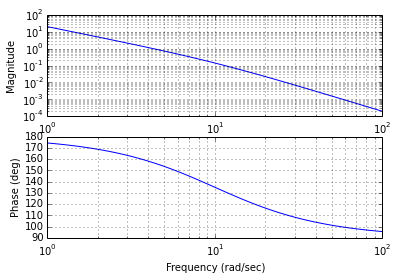

In [30]:
control.bode(tf_u_pitch_2_theta);

In [31]:
cntr_pitch = 1*control.tf([1, 1], [1])
cntr_pitch


s + 1
-----
  1

(None, 34.126716408593865, 12.478204767679284, None)

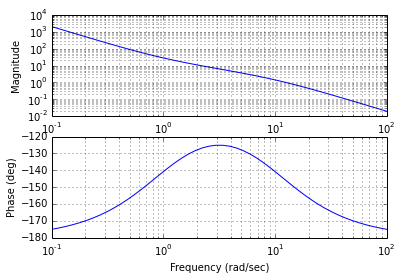

In [32]:
control.bode(tf_u_pitch_2_theta*cntr_pitch);
control.margin(tf_u_pitch_2_theta*cntr_pitch)

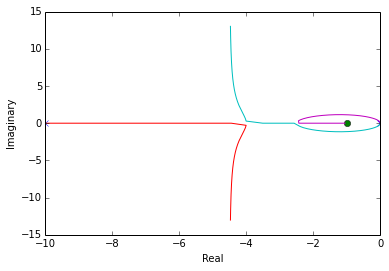

In [33]:
control.rlocus(tf_u_pitch_2_theta*cntr_pitch, klist=pl.linspace(0,1,1000));

## Yaw Channel

In [34]:
tf_u_yaw_2_psi = clean_tf(control.ss2tf(ss0[x_names['psi'], u_names['u_yaw']]))
tf_u_yaw_2_psi


    3.942
------------
s^3 + 10 s^2

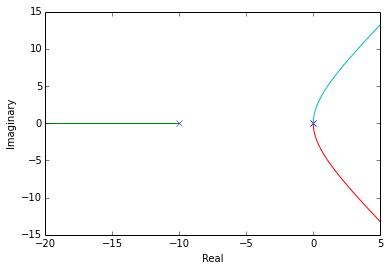

In [35]:
control.rlocus(tf_u_yaw_2_psi);

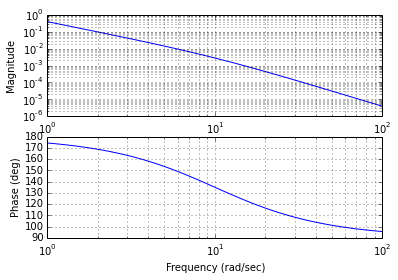

In [36]:
control.bode(tf_u_yaw_2_psi);

In [37]:
cntr_yaw = 10*control.tf([1, 1], [1])
cntr_yaw


10 s + 10
---------
    1

(None, 54.438678145795166, 3.8084237591201768, None)

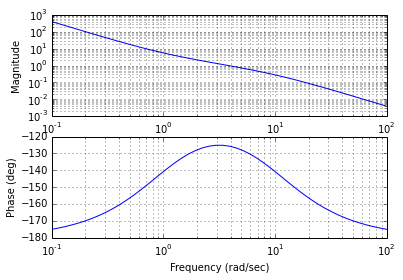

In [38]:
control.bode(tf_u_yaw_2_psi*cntr_yaw);
control.margin(tf_u_yaw_2_psi*cntr_yaw)

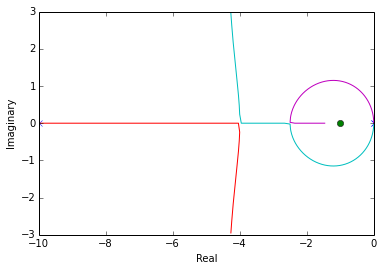

In [39]:
control.rlocus(tf_u_yaw_2_psi*cntr_yaw, klist=pl.linspace(0,1,1000));

In [40]:
K = control.lqr(ss0.A, ss0.B, pl.eye(ss0.A.shape[0]), pl.eye(ss0.B.shape[1]))[0];

In [41]:
u_vect.T, x_vect.T

([u_roll  u_pitch  u_thr  u_yaw], [U  V  W  P  Q  R  φ  θ  ψ  p_N  p_E  p_D  ω
₁  ω₂  ω₃  ω₄])

In [42]:
K_clean = pl.where(abs(K) > 1e-3, K, pl.zeros(K.shape))
K_clean

array([[ 0.        ,  1.46113957,  0.        ,  1.53808562,  0.        ,
         1.26912749,  6.52467648,  0.        ,  0.34118581,  0.        ,
         0.93999587,  0.        , -0.54560988,  0.79841309,  0.545576  ,
        -0.79840491],
       [-1.5806131 ,  0.        ,  0.10416873,  0.        ,  1.85620967,
         0.        ,  0.        ,  7.42068257,  0.        , -0.99541653,
         0.        ,  0.09563435,  0.62870776, -0.63643453,  0.62867253,
        -0.6364277 ],
       [-0.15185693,  0.        , -1.08424724,  0.        ,  0.1783348 ,
         0.        ,  0.        ,  0.71293987,  0.        , -0.09563435,
         0.        , -0.99541653,  0.66862645,  0.67635456,  0.6685824 ,
         0.67633623],
       [ 0.        , -0.53023155,  0.        , -0.53624422,  0.        ,
         3.49624733, -2.36116273,  0.        ,  0.93999587,  0.        ,
        -0.34118581,  0.        , -0.24318591, -0.49598778,  0.24314052,
         0.49597078]])

In [43]:
u_vect

⎡u_roll ⎤
⎢       ⎥
⎢u_pitch⎥
⎢       ⎥
⎢ u_thr ⎥
⎢       ⎥
⎣ u_yaw ⎦